#**LangGraph chatbot with Memory and Thread**

---



 ### **Install dependencies**

In [42]:
!pip install langgraph langchain-core langchain-openai gradio langgraph-prebuilt


###**Retrive API key from Secrets and Set as an ENV**

In [43]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set OPENAI_API_KEY as an ENV
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [44]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", streaming=True)

### **Import Statements**

###**Chat with LLM and Tools**

In [53]:
import gradio as gr
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver


# 2. Define tools
def add(a: int, b: int) -> int:
    """Addition"""
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiplication"""
    return a * b

def divide(a: int, b: int) -> float:
    """Division"""
    return a / b

tools = [add, multiply, divide]

# 2. Set up LLM
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(content="You are a helpful assistant who performs calculations and remembers previous results.")

# 3. Assistant Node (calls tools)
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# New direct reply node (LLM without tools)
def assistant_direct_reply(state: MessagesState):
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

# 4. Build LangGraph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add the new direct reply node
builder.add_node("direct_reply", assistant_direct_reply)

# Conditional edges include the new direct reply branch
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "tools": "tools",
        "direct": "direct_reply",  # New branch for direct LLM reply
        END : END
    }
)

builder.set_entry_point("assistant")

# 5. Compile with memory
memory = MemorySaver()
chat_graph = builder.compile(checkpointer=memory)

# 6. Run a test
thread_id = "test-thread-001"
config = {"configurable": {"thread_id": thread_id}}

print("\n🔁 Chat started. Type 'exit' to stop.")
while True:
    user_input = input("\nYou: ")
    if user_input.lower() == "exit":
        break
    message = HumanMessage(content=user_input)
    result = chat_graph.invoke({"messages": [message]}, config)
    response = result["messages"][-1].content
    print(f"Assistant: {response}")



🔁 Chat started. Type 'exit' to stop.

You: hi
Assistant: Hello! How can I assist you today?

You: I am Neependra Khare, from Bangaluru. can you help me in my study?
Assistant: Of course, Neependra! I'd be happy to help with your studies. What subject or topic are you currently studying?

You: I have doubt in social studies.
Assistant: Great! I'd be glad to help with social studies. What specific topic or question do you have a doubt about?

You: can you do multiplication of 5 and 9
Assistant: 45

You: can you add 10 in that?
Assistant: 55

You: Who am I? 
Assistant: You mentioned earlier that you are Neependra Khare from Bengaluru. Is there anything else you'd like to know or discuss?

You: In which subject I have a query?
Assistant: You mentioned that you have a query in social studies. If you have specific questions or need help with a particular topic within social studies, feel free to ask!

You: Thank you
Assistant: You're welcome! If you have any more questions or need further a

###**Graph**

In [54]:
# Visualize the workflow (requires graphviz)
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

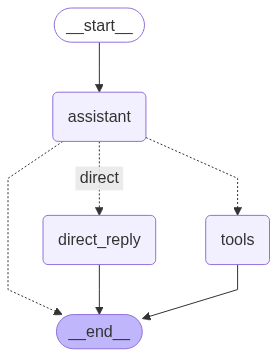

In [55]:
display(
    Image(
        chat_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)